# Slow-ramp lithiation

- Code for Cahn-Hilliard phase separation with mechanical coupling
- This is a two-dimensional  axisymmetric simulation
- Slow ramp lithiation

# Degrees of freedom
- mechanical dispalcement: u
- chemical potential: mu
- concentration: c

# Units
- Length: um
- Mass: kg
- Time: s
- Amount of substance: pmol
- Temperature: K

- Mass density: kg/um^3
- Force: uN
- Stress: MPa 
- Energy: pJ
- Species concentration: pmol/um^3
- Chemical potential: pJ/pmol
- Molar volume: um^3/pmol
- Species diffusivity: um^2/s
- Boltzmann Constant: 1.38E-11 pJ/K
- Gas constant: 8.3145  pJ/(pmol K)


### Software:
- Dolfinx v0.8.0

Eric Stewart and Lallit Anand  

ericstew@mit.edu and anand@mit.edu   

June 2024

# Import modules

In [1]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 lt, gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [2]:
# Ellipse major axis
a0 = 0.5 # um 
# Ellipse minor axis
b0 = 0.3 #um

# Read in the 2D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/axi_ellipse.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 1D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_axi_ellipse.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

# A single point at the center of the inclusion for "grounding" the displacement of the inclusion
def ground(x):
    return np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 0))

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell number indices**

In [3]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values   # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))           # printing the unique indices

# Gmsh numbering
# Physical Surface("particle", 8)  

[8]


**Print out the unique edge index numbers**

In [4]:
top_imap = domain.topology.index_map(1)      # index map of 1D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

# Curve labels from Gmsh
#
# //+
# Physical Curve("left", 5)  
# //+
# Physical Curve("bottom", 6)  
# //+
# Physical Curve("outer", 7)   


[5 6 7]


## Define boundary and volume integration measure

In [5]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':4})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 4})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

------------------------------------
Simulation start
------------------------------------
Step: Lithiate |   Increment: 0 | Iterations: 3
Simulation Time: 0.01 s | dt: 0.01 s

Step: Lithiate |   Increment: 1 | Iterations: 2
Simulation Time: 0.03 s | dt: 0.015 s

Step: Lithiate |   Increment: 2 | Iterations: 2
Simulation Time: 0.05 s | dt: 0.022 s

Step: Lithiate |   Increment: 3 | Iterations: 2
Simulation Time: 0.08 s | dt: 0.034 s

Step: Lithiate |   Increment: 4 | Iterations: 2
Simulation Time: 0.13 s | dt: 0.051 s

Step: Lithiate |   Increment: 5 | Iterations: 3
Simulation Time: 0.21 s | dt: 0.076 s

Step: Lithiate |   Increment: 6 | Iterations: 3
Simulation Time: 0.32 s | dt: 0.114 s

Step: Lithiate |   Increment: 7 | Iterations: 3
Simulation Time: 0.49 s | dt: 0.171 s

Step: Lithiate |   Increment: 8 | Iterations: 3
Simulation Time: 0.75 s | dt: 0.256 s

Step: Lithiate |   Increment: 9 | Iterations: 3
Simulation Time: 1.13 s | dt: 0.384 s

Step: Lithiate |   Increment: 10 | Itera

2024-06-21 19:31:51.322 ( 171.241s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 833 | Iterations: 5
Simulation Time: 1068.44 s | dt: 0.649 s

Step: Lithiate |   Increment: 834 | Iterations: 5
Simulation Time: 1069.09 s | dt: 0.649 s



2024-06-21 19:31:53.329 ( 173.248s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 835 | Iterations: 5
Simulation Time: 1069.41 s | dt: 0.324 s



2024-06-21 19:31:55.528 ( 175.447s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 836 | Iterations: 4
Simulation Time: 1069.58 s | dt: 0.162 s

Step: Lithiate |   Increment: 837 | Iterations: 6
Simulation Time: 1069.82 s | dt: 0.243 s

Step: Lithiate |   Increment: 838 | Iterations: 5
Simulation Time: 1069.94 s | dt: 0.122 s

Step: Lithiate |   Increment: 839 | Iterations: 7
Simulation Time: 1070.06 s | dt: 0.122 s

Step: Lithiate |   Increment: 840 | Iterations: 5
Simulation Time: 1070.12 s | dt: 0.061 s

Step: Lithiate |   Increment: 841 | Iterations: 5
Simulation Time: 1070.18 s | dt: 0.061 s

Step: Lithiate |   Increment: 842 | Iterations: 5
Simulation Time: 1070.25 s | dt: 0.061 s

Step: Lithiate |   Increment: 843 | Iterations: 5
Simulation Time: 1070.31 s | dt: 0.061 s

Step: Lithiate |   Increment: 844 | Iterations: 5
Simulation Time: 1070.37 s | dt: 0.061 s

Step: Lithiate |   Increment: 845 | Iterations: 5
Simulation Time: 1070.43 s | dt: 0.061 s

Step: Lithiate |   Increment: 846 | Iterations: 5
Simulation Time: 1070.49 s | d

2024-06-21 19:37:25.882 ( 505.801s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 831 | Iterations: 5
Simulation Time: 1065.85 s | dt: 0.649 s



2024-06-21 19:37:28.908 ( 508.826s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 832 | Iterations: 4
Simulation Time: 1066.17 s | dt: 0.324 s



2024-06-21 19:37:32.401 ( 512.319s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 833 | Iterations: 5
Simulation Time: 1066.41 s | dt: 0.243 s

Step: Lithiate |   Increment: 834 | Iterations: 6
Simulation Time: 1066.66 s | dt: 0.243 s

Step: Lithiate |   Increment: 835 | Iterations: 5
Simulation Time: 1066.78 s | dt: 0.122 s



2024-06-21 19:37:35.071 ( 514.990s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 836 | Iterations: 5
Simulation Time: 1066.84 s | dt: 0.061 s



2024-06-21 19:37:36.839 ( 516.758s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 837 | Iterations: 4
Simulation Time: 1066.87 s | dt: 0.03 s

Step: Lithiate |   Increment: 838 | Iterations: 7
Simulation Time: 1066.92 s | dt: 0.046 s

Step: Lithiate |   Increment: 839 | Iterations: 5
Simulation Time: 1066.94 s | dt: 0.023 s

Step: Lithiate |   Increment: 840 | Iterations: 6
Simulation Time: 1066.96 s | dt: 0.023 s

Step: Lithiate |   Increment: 841 | Iterations: 5
Simulation Time: 1066.97 s | dt: 0.011 s

Step: Lithiate |   Increment: 842 | Iterations: 5
Simulation Time: 1066.98 s | dt: 0.011 s

Step: Lithiate |   Increment: 843 | Iterations: 5
Simulation Time: 1067.0 s | dt: 0.011 s

Step: Lithiate |   Increment: 844 | Iterations: 5
Simulation Time: 1067.01 s | dt: 0.011 s

Step: Lithiate |   Increment: 845 | Iterations: 4
Simulation Time: 1067.02 s | dt: 0.011 s

Step: Lithiate |   Increment: 846 | Iterations: 5
Simulation Time: 1067.04 s | dt: 0.017 s

Step: Lithiate |   Increment: 847 | Iterations: 5
Simulation Time: 1067.05 s | dt:

2024-06-21 19:44:03.031 ( 902.946s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 830 | Iterations: 4
Simulation Time: 1064.55 s | dt: 0.649 s



2024-06-21 19:44:04.796 ( 904.711s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 831 | Iterations: 5
Simulation Time: 1065.04 s | dt: 0.487 s

Step: Lithiate |   Increment: 832 | Iterations: 6
Simulation Time: 1065.52 s | dt: 0.487 s

Step: Lithiate |   Increment: 833 | Iterations: 7
Simulation Time: 1065.77 s | dt: 0.243 s



2024-06-21 19:44:08.481 ( 908.397s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 834 | Iterations: 4
Simulation Time: 1065.83 s | dt: 0.061 s



2024-06-21 19:44:10.937 ( 910.853s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 835 | Iterations: 4
Simulation Time: 1065.87 s | dt: 0.046 s



2024-06-21 19:44:13.426 ( 913.342s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 836 | Iterations: 4
Simulation Time: 1065.91 s | dt: 0.034 s



2024-06-21 19:44:15.071 ( 914.987s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 837 | Iterations: 4
Simulation Time: 1065.93 s | dt: 0.026 s

Step: Lithiate |   Increment: 838 | Iterations: 6
Simulation Time: 1065.97 s | dt: 0.038 s

Step: Lithiate |   Increment: 839 | Iterations: 5
Simulation Time: 1065.99 s | dt: 0.019 s

Step: Lithiate |   Increment: 840 | Iterations: 6
Simulation Time: 1066.01 s | dt: 0.019 s

Step: Lithiate |   Increment: 841 | Iterations: 5
Simulation Time: 1066.02 s | dt: 0.01 s

Step: Lithiate |   Increment: 842 | Iterations: 5
Simulation Time: 1066.03 s | dt: 0.01 s

Step: Lithiate |   Increment: 843 | Iterations: 5
Simulation Time: 1066.04 s | dt: 0.01 s

Step: Lithiate |   Increment: 844 | Iterations: 5
Simulation Time: 1066.05 s | dt: 0.01 s

Step: Lithiate |   Increment: 845 | Iterations: 5
Simulation Time: 1066.06 s | dt: 0.01 s

Step: Lithiate |   Increment: 846 | Iterations: 5
Simulation Time: 1066.07 s | dt: 0.01 s

Step: Lithiate |   Increment: 847 | Iterations: 5
Simulation Time: 1066.08 s | dt: 0.0

2024-06-21 19:45:22.218 ( 982.133s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 1031 | Iterations: 5
Simulation Time: 1073.02 s | dt: 0.082 s

Step: Lithiate |   Increment: 1032 | Iterations: 5
Simulation Time: 1073.11 s | dt: 0.082 s



2024-06-21 19:45:24.241 ( 984.156s) [main            ]       NewtonSolver.cpp:270   WARN| Newton solver did not converge.


Step: Lithiate |   Increment: 1033 | Iterations: 5
Simulation Time: 1073.15 s | dt: 0.041 s

Step: Lithiate |   Increment: 1034 | Iterations: 5
Simulation Time: 1073.19 s | dt: 0.041 s

Step: Lithiate |   Increment: 1035 | Iterations: 5
Simulation Time: 1073.23 s | dt: 0.041 s

Step: Lithiate |   Increment: 1036 | Iterations: 7
Simulation Time: 1073.27 s | dt: 0.041 s

Step: Lithiate |   Increment: 1037 | Iterations: 5
Simulation Time: 1073.29 s | dt: 0.021 s

Step: Lithiate |   Increment: 1038 | Iterations: 5
Simulation Time: 1073.31 s | dt: 0.021 s

Step: Lithiate |   Increment: 1039 | Iterations: 4
Simulation Time: 1073.33 s | dt: 0.021 s

Step: Lithiate |   Increment: 1040 | Iterations: 4
Simulation Time: 1073.36 s | dt: 0.031 s

Step: Lithiate |   Increment: 1041 | Iterations: 5
Simulation Time: 1073.41 s | dt: 0.046 s

Step: Lithiate |   Increment: 1042 | Iterations: 4
Simulation Time: 1073.46 s | dt: 0.046 s

Step: Lithiate |   Increment: 1043 | Iterations: 4
Simulation Time: 10

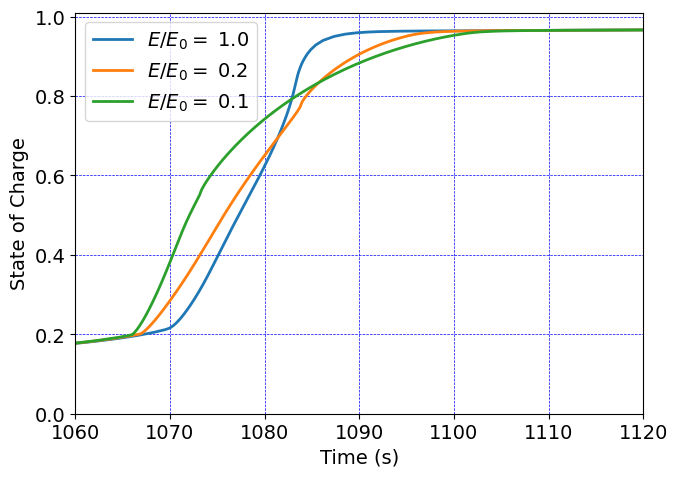

In [6]:
for factor in [1.0, 0.2, 0.1]:

    # Material parameters after Di Leo et al. (2014)
    #
    Gshear   = Constant(domain,PETSc.ScalarType(49.8e3*factor))    # Shear modulus, MPa
    Kbulk    = Constant(domain,PETSc.ScalarType(83e3*factor))      # Bulk modulus, MPa
    #
    Omega    = Constant(domain,PETSc.ScalarType(4.05))      # Molar volume, um^3/pmol 
    D        = Constant(domain,PETSc.ScalarType(1e-2))      # Diffusivity, um^2/s 
    chi      = Constant(domain,PETSc.ScalarType(3))         # Phase parameter, (-)
    cMax     = Constant(domain,PETSc.ScalarType(2.29e-2))   # Saturation concentration, pmol/um^3
    lam      = Constant(domain,PETSc.ScalarType(5.5749e-1)) # Interface parameter, (pJ/pmol) um^2
    #
    theta0   = Constant(domain,PETSc.ScalarType(298))        # Reference temperature, K
    R_gas    = Constant(domain,PETSc.ScalarType(8.3145))    # Gas constant, pJ/(pmol K)
    RT       = Constant(domain,PETSc.ScalarType(R_gas*theta0))


    # %%
    t     = 0.0   # initialization of time
    Ttot  = 1800  # Total time, s
    dt    = 0.01   # Initial time step size, here we will use adaptive time-stepping

    # Time step field, constant within body
    dk = Constant(domain, PETSc.ScalarType(dt))

    # Initial and final cBar values
    cBar_i = Constant(domain, PETSc.ScalarType(0.005))
    cBar_f = Constant(domain, PETSc.ScalarType(0.995))

    # Corresponding (normalized) chemical potential values
    mu_i =   Constant(domain, PETSc.ScalarType(ln(cBar_i/(1-cBar_i)) + float(chi)*(1-2*cBar_i)))
    mu_f =   Constant(domain, PETSc.ScalarType(ln(cBar_f/(1-cBar_f)) + float(chi)*(1-2*cBar_f)))

    def muRamp(t):
        return mu_i + (mu_f - mu_i)*(t/Ttot)

    # %% [markdown]
    # # Function spaces

    # %%
    # Define function space, both vectorial and scalar
    U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # For displacement
    P1 = element("Lagrange", domain.basix_cell(), 1) # Forchemical potential and species concentration 
    #                                      
    TH = mixed_element([U2, P1, P1])     # Mixed element
    ME = functionspace(domain, TH)    # Total space for all DOFs

    # Define actual functions with the required DOFs
    w = Function(ME)
    u, mu, c = split(w)  # chemical potential mu and concentration c

    # A copy of functions to store values in the previous step for time-stepping
    w_old = Function(ME)
    u_old, mu_old, c_old = split(w_old)   

    # Define test functions    
    u_test, mu_test, c_test  = TestFunctions(ME)  

    # Define trial functions needed for automatic differentiation
    dw = TrialFunction(ME)                  

    # %% [markdown]
    # # Initial conditions

    # %%
    # Assign initial  normalized chemical potential  mu_i to the domain
    w.sub(1).interpolate(lambda x: np.full((x.shape[1],),  mu_i))
    w_old.sub(1).interpolate(lambda x: np.full((x.shape[1],), mu_i))  


    # Assign initial  normalized concentration   c_i to the domain
    c_i = Constant(domain, PETSc.ScalarType(cBar_i*cMax*Omega))
    # 
    w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  c_i))
    w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],), c_i)) 

    # %% [markdown]
    # # Subroutines for kinematics and constitutive equations

    # %%
    # Special gradient operators for axisymmetric functions 
    #
    #---------------------------------------------------
    # Gradient of vector field u   
    #---------------------------------------------------
    def axi_grad_vector(u):
        
        grad_u = grad(u)
        
        axi_grad_33_exp = conditional(eq(x[0], 0), 0.0, u[0]/x[0])
        
        axi_grad_u = ufl.as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                    [grad_u[1,0], grad_u[1,1], 0],
                    [0, 0, axi_grad_33_exp]]) 
        
        return axi_grad_u

    #---------------------------------------------------
    # Gradient of scalar field y
    # (just need an extra zero for dimensions to work out)
    #---------------------------------------------------
    def axi_grad_scalar(y):
        
        grad_y = grad(y)
        
        axi_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.])
        
        return axi_grad_y
    #---------------------------------------------------
    # Axisymmetric deformation gradient 
    #---------------------------------------------------
    def F_axi_calc(u):
        
        dim = len(u)                # dimension of problem (2)
        
        Id = Identity(dim)          # 2D Identity tensor
        
        F = Id + grad(u)            # 2D Deformation gradient
        
        F33_exp =  1.0 + u[0]/x[0]  # axisymmetric F33, R/R0 
        
        F33 = conditional(eq(x[0], 0.0), 1.0, F33_exp) # avoid divide by zero at r=0
        
        F_axi =  ufl.as_tensor([[F[0,0], F[0,1], 0],
                    [F[1,0], F[1,1], 0],
                    [0, 0, F33]]) # Full axisymmetric F
        
        return F_axi



    #  Elastic deformation gradient Fe
    def Fe_calc(u,c):
        F = F_axi_calc(u)      # = F
        J = det(F)            # = J
        #
        Js = 1.0 + c          #  what about (c-c_i)?
        Fs = Js**(1/3)*Identity(3) 
        #
        Fe = F*inv(Fs)
        return   Fe    

    # The elastic second Piola stress
    def Te_calc(u, c):
        Id = Identity(3)
        #
        Fe = Fe_calc(u, c)
        Je = det(Fe)
        Ce = Fe.T*Fe
        #
        Cebar = Je**(-2/3)*Ce
        #
        Te = Je**(-2/3)*Gshear*(Id - (1/3)*tr(Cebar)*inv(Cebar))\
            + Kbulk*Je*(Je-1)*inv(Cebar)
        #
        return Te

    # The elastic Mandel stress
    def Me_calc(u, c):
        Fe = Fe_calc(u, c)
        Je = det(Fe)
        Ce = Fe.T*Fe
        #
        Te = Te_calc(u, c)
        #
        Me = Ce*Te
        #
        return Me
    
    # The first Piola stress     
    def Piola_calc(u,c):
        #
        F = F_axi_calc(u)
        J = det(F)
        #
        Fe = Fe_calc(u, c)
        Je = det(Fe)
        #
        Te = Te_calc(u,c)
        #
        T  = Je**(-1)*Fe*Te*inv(Fe)
        #
        Piola  = J*T*inv(F.T)/Gshear 
        return Piola

    #------------------------------------------------------------------------------  
    # Species flux
    def Flux_calc(u, mu, c):
        F = F_axi_calc(u) 
        #
        Cinv = inv(F.T*F) 
        #
        cBar = c/(Omega*cMax) # normalized concentration
        #
        Mob = (D*c)/(Omega*RT)*(1-cBar)*Cinv
        #
        Jmat = - RT* Mob * axi_grad_scalar(mu)
        #
        return Jmat

    # Calculate the f^c term
    def fc_calc(u, c):
        #
        cBar = c/(Omega*cMax) # normalized concentration
        #
        Me = Me_calc(u,c)
        #
        fc   = RT*(ln(cBar/(1-cBar)) + chi*(1-2*cBar) ) - Omega*((1/3)*tr(Me))
        #
        return fc


    # Calculate  principal Cauchy stresses for visualization only
    def tensor_eigs(T):
        # invariants of T
        I1 = tr(T) 
        I2 = (1/2)*(tr(T)**2 - tr(T*T))
        I3 = det(T)
        
        # Intermediate quantities b, c, d
        b = -I1
        c = I2
        d = -I3
        
        # intermediate quantities E, F, G
        E = (3*c - b*b)/3
        F = (2*(b**3) - 9*b*c + 27*d)/27
        G = (F**2)/4 + (E**3)/27
        
        # Intermediate quantities H, I, J, K, L
        H = sqrt(-(E**3)/27)
        I = H**(1/3)
        J = acos(-F/(2*H))
        K = cos(J/3)
        L = sqrt(3)*sin(J/3)
        
        # Finally, the (not necessarily ordered) eigenvalues
        t1 = 2*I*K - b/3
        t2 = -I*(K+L) - b/3
        t3 = -I*(K-L) - b/3
        
        # Order the eigenvalues using conditionals
        #
        T1_temp = conditional(lt(t1, t3), t3, t1 ) # returns the larger of t1 and t3.
        T1 = conditional(lt(T1_temp, t2), t2, T1_temp ) # returns the larger of T1_temp and t2.
        #
        T3_temp = conditional(gt(t3, t1), t1, t3 ) # returns the smaller of t1 and t3.
        T3 = conditional(gt(T3_temp, t2), t2, T1_temp ) # returns the smaller of T3_temp and t2.
        #
        # use the trace to report the middle eigenvalue.
        T2 = I1 - T1 - T3
        
        return T1, T2, T3


    # %% [markdown]
    # # Evaluate kinematics and constitutive relations

    # %%
    # Kinematics
    F = F_axi_calc(u)
    J = det(F) 

    # Calculate the normalized concentration cBar
    cBar = c/(Omega*cMax) # normalized concentration

    # Calculate the Piola stress
    Piola = Piola_calc(u,c)

    # Calculate the Species flux
    Jmat = Flux_calc(u, mu, c)

    # Calculate the f^c term 
    fc = fc_calc(u, c)


    # %% [markdown]
    # # Weak forms

    # %%
    # Residuals:
    # Res_0: Equation of motion (test fxn: u)
    # Res_1: Balance of mass   (test fxn: mu)
    # Res_2: chemical potential (test fxn: c)

    #
    mu_ext_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))

    # Calculate the  spatial species boundary flux:
    j_spat_flux = mu - mu_ext_cons
    #
    Fcof = J*inv(F.T)                 # Cofactor of F
    nvec  =  dot(Fcof,n)              # Recall that we had defined: n = ufl.as_vector([n2D[0], n2D[1], 0.0])
    da_mat  = sqrt(inner(nvec, nvec)) # Areal jacobian
    #
    # Calculate the configuration-dependent referential spcies flux:
    jBar =  j_spat_flux * da_mat

    # The weak form for the equation of motion
    Res_0 = inner(Piola, axi_grad_vector(u_test))*x[0]*dx

    # The weak form for the mass balance of mobile species    
    Res_1 = dot((c - c_old)/dk, mu_test)*x[0]*dx \
            -  Omega*dot(Jmat , axi_grad_scalar(mu_test) )*x[0]*dx \
            + Omega*dot(jBar, mu_test)*x[0]*ds(7)

    # The weak form for the mass balance of mobile species    
    # Res_1 = dot((c - c_old)/dk, mu_test)*x[0]*dx \
    #         -  Omega*dot(Jmat , axi_grad_scalar(mu_test) )*x[0]*dx \
    #         + Omega*dot(jBar, mu_test)*x[0]*ds(7)

    # The weak form for the concentration
    Res_2 = dot(mu - fc/RT, c_test)*x[0]*dx \
            -  dot( (lam/RT)*axi_grad_scalar(cBar), axi_grad_scalar(c_test))*x[0]*dx
            
    # Total weak form
    Res = Res_0 + Res_1 + Res_2

    # Automatic differentiation tangent:
    a = derivative(Res, w, dw)

    # %% [markdown]
    # # # Set-up output files

    # # %%
    # # Set up projection problem for fixing visualization issues
    # # of fields in  the axisymmetric simulation
    # #
    # def setup_projection(u, V):

    #     trial = ufl.TrialFunction(V)
    #     test  = ufl.TestFunction(V)   

    #     a = ufl.inner(trial, test)*x[0]*dx
    #     L = ufl.inner(u, test)*x[0]*dx

    #     projection_problem = dolfinx.fem.petsc.LinearProblem(a, L, [], \
    #         petsc_options={"ksp_type": "cg", "ksp_rtol": 1e-16, "ksp_atol": 1e-16, "ksp_max_it": 1000})
        
    #     return projection_problem

    # # %%
    # # results file name
    # results_name = "axi_ellipse_lithiation_step"

    # # Function space for projection of results
    # U1 = element("DG", domain.basix_cell(), 1, shape=(2,))  # For 2d vector
    # P0 = element("DG", domain.basix_cell(), 1)              # For  scalar 
    # T1 = element("DG", domain.basix_cell(), 1, shape=(3,3)) # For stress tensor

    # V1 = fem.functionspace(domain, P0) # Scalar function space
    # V2 = fem.functionspace(domain, U1) # Vector function space
    # V3 = fem.functionspace(domain, T1) # Tensor function space

    # # basic fields to write to output file
    # u_vis = Function(V2)
    # u_vis.name = "disp"

    # mu_vis = Function(V1)
    # mu_vis.name = "mu"

    # c_vis = Function(V1)
    # c_vis.name = "c"

    # # Project cBar for visualization
    # #
    # cBar_projection = setup_projection(cBar, V1)
    # cBar_vis = cBar_projection.solve()
    # cBar_vis.name = "cBar"

    # # Project the volumetric Jacobian J for visualization
    # #
    # J_projection = setup_projection(J, V1)
    # J_vis = J_projection.solve()
    # J_vis.name = "J"
    
    # # Project the Piola stress tensor for visualization
    # #
    # Piola_projection = setup_projection(Piola, V3)
    # Piola_temp = Piola_projection.solve()

    # T   = Gshear*Piola_temp*F.T/J
    # T0   = T - (1/3)*tr(T)*Identity(3)
    # Mises = sqrt((3/2)*inner(T0, T0))
    # Mises_projection = setup_projection(Mises, V1)
    # Mises_vis = Mises_projection.solve()
    # Mises_vis.name = "Mises"

    # sig1, sig2, sig3 = tensor_eigs(T)
    # #
    # sig1_projection = setup_projection(sig1, V1)
    # sig1_vis = sig1_projection.solve()
    # sig1_vis.name = "sig1"
    # #
    # sig2_projection = setup_projection(sig2, V1)
    # sig2_vis = sig2_projection.solve()
    # sig2_vis.name = "sig2"
    # #
    # sig3_projection = setup_projection(sig3, V1)
    # sig3_vis = sig3_projection.solve()
    # sig3_vis.name = "sig3"
    # # #
    # # sig1_vis = Function(V1)
    # # sig1_vis.name = "sig1"
    # # sig1_expr = Expression(sig1, V1.element.interpolation_points())
    # # #
    # # sig2_vis = Function(V1)
    # # sig2_vis.name = "sig2"
    # # sig2_expr = Expression(sig2, V1.element.interpolation_points())

    # P11 = Function(V1)
    # P11.name = "P11"
    # P11_expr = Expression(Gshear*Piola_temp[0,0],V1.element.interpolation_points())
    # #
    # P22 = Function(V1)
    # P22.name = "P22"
    # P22_expr = Expression(Gshear*Piola_temp[1,1],V1.element.interpolation_points())
    # #
    # P33 = Function(V1)
    # P33.name = "P33"
    # P33_expr = Expression(Gshear*Piola_temp[2,2],V1.element.interpolation_points())

    # # set up the output VTX files.
    # file_results = VTXWriter(
    #     MPI.COMM_WORLD,
    #     "results/" + results_name + ".bp",
    #     [  # put the functions here you wish to write to output
    #         u_vis, mu_vis, c_vis, cBar_vis, J_vis, 
    #         P11, P22, P33, sig1_vis, sig2_vis, sig3_vis, Mises_vis,
    #     ],
    #     engine="BP4",
    # )

    # def writeResults(t):
        
    #     # Re-project some fields. This is necessary here to remove visual artifacts which arise
    #     # due to the axisymmetric formulation as r -> 0
    #     #
    #     Piola_temp     = Piola_projection.solve()
    #     Mises_vis      = Mises_projection.solve()
    #     J_vis          = J_projection.solve()
    #     cBar_vis       = cBar_projection.solve()
    #     sig1_vis       = sig1_projection.solve()
    #     sig2_vis       = sig2_projection.solve()
    #     sig3_vis       = sig3_projection.solve()

    #     # Output field interpolation 
    #     u_vis.interpolate(w.sub(0))
    #     mu_vis.interpolate(w.sub(1))
    #     c_vis.interpolate(w.sub(2))
    #     P11.interpolate(P11_expr)
    #     P22.interpolate(P22_expr)
    #     P33.interpolate(P33_expr)
    #     #    #
    #     #    sig1_vis.interpolate(sig1_expr)
    #     #    sig2_vis.interpolate(sig2_expr)

    #     # Write output fields
    #     file_results.write(t) 
            

    # %% [markdown]
    # # Infrastructure for pulling out time history data (displacement, force, etc.)

    # %%

    # # Identify point for reporting temperature
    # pointForDisp = np.array([r_out,L0/2,0.0])

    # bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
    # cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
    # colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array

    # Form for evaluating the state of charge  SOC at each step
    # ( SOC = Tot_chg / Tot_vol )
    #
    Tot_chg = fem.form(2.0*np.pi* cBar *x[0]*dx)
    #
    Tot_vol = fem.form(2.0*np.pi*x[0]*dx)

    # The (referential) volume is constant, so just evaluate it once before running the simulation:
    #
    Tot_vol_val = domain.comm.gather(fem.assemble_scalar(Tot_vol))[0]

    # %% [markdown]
    # # Analysis Step 

    # %%
    # Give the step a descriptive name
    step = "Lithiate"

    # %% [markdown]
    # ## Boundary conditions

    # %%
    # Constant for applied chemical potential
    mu_cons = Constant(domain,PETSc.ScalarType(muRamp(0)))

    # Recall gmsh curve  names and numbers
    # Physical Curve("left", 5)  
    # //+
    # Physical Curve("bottom", 6)  
    # //+
    # Physical Curve("outer", 7)   


    # Find the specific DOFs which will be constrained
    xBot_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(5))
    yBot_u2_dofs = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(6))
    #
    #outer_mu_dofs = fem.locate_dofs_topological(ME.sub(1), facet_tags.dim, facet_tags.find(7))

    # Build Dirichlet BCs
    bcs_1 = dirichletbc(0.0, xBot_u1_dofs, ME.sub(0).sub(0)) # u1 fix -  left
    bcs_2 = dirichletbc(0.0, yBot_u2_dofs, ME.sub(0).sub(1)) # u2 fix - bottom
    #

    bcs = [bcs_1,bcs_2]

    # %% [markdown]
    # ## Define the nonlinear variational problem

    # %%
    # Set up nonlinear problem
    problem = NonlinearProblem(Res, w, bcs, a)

    # The global newton solver and params
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-8
    solver.atol = 1e-8
    solver.max_it = 50
    solver.report = True
    solver.error_on_nonconvergence = False

    #  The Krylov solver parameters.
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "preonly"  
    opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    opts[f"{option_prefix}ksp_max_it"] = 30
    ksp.setFromOptions()

    # %% [markdown]
    # # Initialize arrays for storing output history

    # %%
    #Arrays for storing output history
    totSteps = 100000
    timeHist0 = np.zeros(shape=[totSteps])
    timeHist1 = np.zeros(shape=[totSteps]) 
    # # timeHist2 = np.zeros(shape=[totSteps]) 
    # # timeHist3 = np.zeros(shape=[totSteps])
    # # #
    # # timeHist3[0] = mu0 # Initialize the chemical potential

    # Initialize a counter for reporting data
    ii = 0

    # # Write initial state to file
    # writeResults(t=0.0) 

    # %% [markdown]
    # ##  Start calculation loop

    # %%
    print("------------------------------------")
    print("Simulation start")
    print("------------------------------------")
    # Store start time 
    startTime = datetime.now()

    # Time-stepping solution procedure loop
    while (round(t, 9) <= Ttot):
        
        # increment time
        t += dt 
        
        # update time variables in time-dependent BCs 
        mu_ext_cons.value = float(muRamp(t))
        
    # Solve the problem
        (iter, converged) = solver.solve(w)
        
        # Now we start the adaptive time-stepping and output storage procedure.
        #
        # First, we check if the newton solver actually converged.
        if converged: 

            # Collect results from MPI ghost processes
            w.x.scatter_forward()
            
            # Write output to file
            # writeResults(t)

            # If the solver converged, we print the status of the solver, 
            # perform adaptive time-stepping updates, output results, and 
            # update degrees of freedom for the next step, w_old <- w.
            
            # print progress of calculation periodically
            if ii%1 == 0:      
                now = datetime.now()
                current_time = now.strftime("%H:%M:%S")
                print("Step: {} |   Increment: {} | Iterations: {}".format(step, ii, iter))
                print("Simulation Time: {} s | dt: {} s".format(round(t,2), round(dt, 3)))
                print()   
            
            # Iteration-based adaptive time-stepping
            #
            # If the newton solver takes 2 or less iterations, 
            # increase the time step by a factor of 1.5:
            if ((iter<=4) and (dt<1)):
                dt = 1.5*dt
                dk.value = dt
            # If the newton solver takes 5 or more iterations, 
            # decrease the time step by a factor of 2:
            elif iter>=6:
                dt = dt/2
                dk.value = dt
            # otherwise the newton solver took 3-4 iterations,
            # in which case leave the time step alone.

            # update the DOFs for the next step.
            w_old.x.array[:] = w.x.array
            
            # Increment counter
            ii += 1
            
            # Store time history variables
            timeHist0[ii] = t # current time
            timeHist1[ii] = domain.comm.gather(fem.assemble_scalar(Tot_chg))[0] / Tot_vol_val # time history of State of charge
        
        # If solver doesn't converge we have to back up in time,
        # cut the size of the time step, and try solving again.
        else: # not(converged)
            
            # first, we back up in time
            # ( to un-do the current time step )
            t = t - float(dk)
            
            # Then, we cut back on the time step we're attempting.
            # (by a factor of 2)
            dt = dt/2
            dk.value = dt 

            # Re-set the DOFs to their value before the failed step.
            w.x.array[:] = w_old.x.array

            # Set up nonlinear problem
            problem = NonlinearProblem(Res, w, bcs, a)

            # The global newton solver and params
            solver = NewtonSolver(MPI.COMM_WORLD, problem)
            solver.convergence_criterion = "incremental"
            solver.rtol = 1e-8
            solver.atol = 1e-8
            solver.max_it = 50
            solver.report = True
            solver.error_on_nonconvergence = False
    


    # close the output file.
    # file_results.close()
            
            
    # End analysis
    print("-----------------------------------------")
    print("End computation")                 
    # Report elapsed real time for the analysis
    endTime = datetime.now()
    elapseTime = endTime - startTime
    print("------------------------------------------")
    print("Elapsed real time:  {}".format(elapseTime))
    print("------------------------------------------")


    # %%
    # set plot font to size 14
    font = {'size'   : 14}
    plt.rc('font', **font)

    # Only plot as far as we have time history data
    ind = np.argmax(timeHist0)

    # Get array of default plot colors
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    # Create figure  
    #-------------------------------------------------------------
    plt.plot(timeHist0[0:ind], timeHist1[0:ind], linewidth=2.0,\
        #   color='r', marker='o', markersize=3)
          label=r"$E/E_0 = $ {}".format(factor) )
    #-------------------------------------------------------------
    plt.axis('tight')
    plt.ylabel(r"State of Charge")
    plt.xlabel(r"Time (s)")
    plt.grid(linestyle="--", linewidth=0.5, color='b')
    plt.ylim(0,1.01)
    plt.xlim(1060,1120)

     
plt.legend()
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/ellipse_lithiation_slow_ramp_curves_detail.png", dpi=600)